### ALGORITHM

TRAINING
1. Generate a noisy sprite
2. Choose the closest goal sprite from the training data (hamming distance)
3. Destroy the goal sprite (sequentially over pixles) until it matches the noisy sprite
4. Add the level repair step to the training data
5. Repeat until it matches the noise

---

GENERATION 
1. Initialize a noisy sprite
2. Randomly or sequentially pick/fix a pixel
3. Feed the level into the network to output a repair value
4. Update the pixel with the value
5. If the current sprite isn't valid, keep going

### Imports and Configuration

In [114]:
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib.colors import ListedColormap
from tqdm import tqdm
from sentence_transformers import SentenceTransformer

# tensorflow
import tensorflow as tf
# from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, Conv2DTranspose, Flatten, Layer, Reshape, Input, LeakyReLU, MaxPooling2D, Concatenate, Conv1D, Lambda
from tensorflow.keras.models import Model


%matplotlib inline

In [4]:
#import from Python folder to get the utils
import sys
sys.path.append('../Python')
from utils import picoSS2np, showMultiSprPalette, showMultiSprRGB, showSprRGB, showSprPalette, animatePal

/Users/milk/Desktop/GIL_Lab/BMO/BMO_chatbot_prototype/bmo-venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
### CONSTANT VARIABLES   ###

# PICO-8 Palette => use colormap for matplotlib
PICO_PALETTE = ['#000000','#1D2B53','#7E2553','#008751','#AB5236','#5F574F','#C2C3C7','#FFF1E8','#FF004D','#FFA300','#FFEC27','#00E436','#29ADFF','#83769C','#FF77A8','#FFCCAA']


Food Dataset shape: (100, 8, 8)
Char Dataset shape: (100, 8, 8)


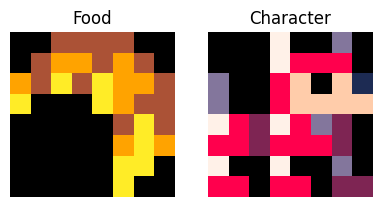

In [6]:
# import from the PICO sprites posted onto Twitter 
# Food: https://twitter.com/JUSTIN_CYR/status/634546317713391616
# Characters: https://twitter.com/johanvinet/status/635814153601597441
pico_food_dat = np.load('../data/rip_data/pico_food.npy',allow_pickle=True)
pico_char_dat = np.load('../data/rip_data/pico_characters.npy',allow_pickle=True)

print(f"Food Dataset shape: {pico_food_dat.shape}")
print(f"Char Dataset shape: {pico_char_dat.shape}")

# show a random food and character sprite 
rand_food = random.choice(pico_food_dat)
rand_char = random.choice(pico_char_dat)
showMultiSprPalette([rand_food,rand_char],textArr=['Food','Character'])

In [119]:
# import sentence-transformer for text embedding 
SBERT_MODEL = SentenceTransformer('bert-base-nli-mean-tokens')

def sentEmb(txt):
    return SBERT_MODEL.encode([txt])[0]

# import the text data
pico_char_labels = np.array([l.strip() for l in open('../data/rip_data/character_desc.txt','r').readlines()])

# encode the labels
pico_char_labels_emb = []
with tqdm(total=len(pico_char_labels)) as pbar:
    pbar.set_description("Encoding labels")
    for l in pico_char_labels:
        pico_char_labels_emb.append(sentEmb(l))
        pbar.update(1)

Encoding labels: 100%|██████████| 100/100 [00:07<00:00, 13.96it/s]


Character: a large yellow turtle with red hair and a large mouth


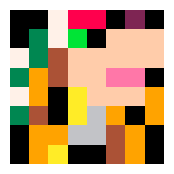

Encoding length: 768


In [121]:
# show a random character and its description
rand_char_idx = random.randint(0,len(pico_char_labels))
print(f"Character: {pico_char_labels[rand_char_idx]}")
showSprPalette(pico_char_dat[rand_char_idx])

desc_enc = pico_char_labels_emb[rand_char_idx]
print(f"Encoding length: {len(desc_enc)}")

In [151]:
###   CONFIUGURATIONS   ###

EXPERIMENT = "text_enc"

GEN_CONF = {
    "EPOCHS" : 50,
    "BATCH_SIZE" : 64,
    "LEARNING_RATE" : 0.0001,
    "WINDOW" : 8
}

CONFIGS = {
    "normal": {
        "NEW_TRAIN_DAT" : True,
        "TRAIN_DAT_PATH" : f'../data/rip_data/POD_dat/POD_train_dat_w{GEN_CONF["WINDOW"]}.npy',
        "TRAIN_NPOD" : False,
        "NPOD_MODEL" : f"../models/gen_models/pod/npod_char-{GEN_CONF['EPOCHS']}eR_w{GEN_CONF['WINDOW']}.h5",
        "SANITY" : False
    },
    "text_enc": {
        "NEW_TRAIN_DAT" : False,
        "TRAIN_DAT_PATH" : f'../data/rip_data/POD_dat/tePOD_train_dat_w{GEN_CONF["WINDOW"]}.npy',
        "TRAIN_TEPOD" : False,
        "TEPOD_MODEL" : f"../models/gen_models/pod/tepod_char-{GEN_CONF['EPOCHS']}eR_w{GEN_CONF['WINDOW']}.h5",
        "SANITY" : False
    }
}


### Normal PoD

---

#### Notes

[window size: 5]
[epochs: 50]
- Abstract art-esque - not quite character looking though

[window size: 8]
[epochs: 50]
- More character definition. Much more cohesive

[window size: 9]
[epochs: 50]
- Not much change but makes a 'character' at earlier iterations

[window size: 9 - TMNT edition]
[epochs: 10 (reached 98%)]
- perfectly recreates ninja turtles every time; can replace a tile with the same tile

[window size: 4]
[epochs: 50]
- "there is a SHAPE" - Dipika




In [59]:
class NormalPoD():
    def __init__(self,spr_shape, channels=16, pad_val=0, crop_size=5):
        self.destroy_data = []
        self.spr_shape = spr_shape
        self.channels = channels
        self.pad_val = pad_val
        self.crop_size = crop_size

    # make a new noisy sprite using the channels and size
    def init_noise_sprite(self):
        noise_spr = np.random.randint(self.channels,size=(self.spr_shape[0],self.spr_shape[1]))
        return noise_spr

    # crop a sprite from the noise sprite (use with padding) - assume pos is (x,y) and center of target crop
    def crop(self, spr, pos, size=5):
        hpad = size//2
        pad_spr = np.pad(spr,((hpad,hpad),(hpad,hpad)),constant_values=self.pad_val)   # pad the sprite 
        crop_spr = pad_spr[pos[0]:pos[0]+size,pos[1]:pos[1]+size]   # get the cropped sprite (should be size,size)
        return pad_spr, crop_spr

    # return the new level and the tile replaced (also add to training data) - assume pos is (x,y)
    def destroy(self, cur_spr, bad_spr, pos, crop_size=5):
        # turn the cur_spr value at the pos to the bad_spr value
        cur_spr2 = np.copy(cur_spr)
        og_val = cur_spr[pos[0],pos[1]]
        cur_spr2[pos[0],pos[1]] = bad_spr[pos[0],pos[1]]

        # crop around the area and add to training data
        _, crop_spr = self.crop(cur_spr2,pos,crop_size)

        return cur_spr2, og_val, crop_spr
    
    # calculate the hamming distance from 2 sprites
    def calc_ham_dist(self, spr1, spr2):
        return np.sum(spr1 != spr2)

    # return the sprite that is closest in hamming distance from the goal set
    def closest_spr(self, goal_set, noise_spr):
        min_dist_i = np.argmin([self.calc_ham_dist(noise_spr, i) for i in goal_set])
        return goal_set[min_dist_i]

    
    # make the training data for the path of destruction
    def make_train_dat(self,goal_set,num_noise_spr=1000):
        train_dat = []
        with tqdm(total=num_noise_spr) as pbar:
            for i in range(num_noise_spr):
                # make a noise sprite and find the closest
                # noise_spr = self.init_noise_sprite()
                # targ_spr = self.closest_spr(goal_set,noise_spr).copy()

                #go through each goal sprite and make a noise sprite for it
                targ_spr = goal_set[i%len(goal_set)]
                noise_spr = self.init_noise_sprite()

                # make a list of all the positions in the sprite and shuffle it
                pos_set = []
                for x in range(self.spr_shape[0]):
                    for y in range(self.spr_shape[1]):
                        pos_set.append((x,y))
                random.shuffle(pos_set)

                # iterate over the goal sprite and change until it matches the noise spr (destroy)
                for p in pos_set:
                        # destroy the noise sprite
                        targ_spr, og_val, crop_spr = self.destroy(targ_spr,noise_spr,p,self.crop_size)
                        train_dat.append([crop_spr,og_val])
                        # showSprPalette(targ_spr)
                pbar.update(1)
                    
        return train_dat
    
    # make the path of destruction neural network model
    # copy of architecture from the paper [Conv(128,3) -> Conv(128,3) -> MaxPool(2), Conv(256,3)]
    # it doesn't work though... at least not with 5x5 crop size - need to ask Sam for exact implementation
    def makePoDCNN(self):
        self.pod_model = Sequential([
            InputLayer(input_shape=(self.crop_size,self.crop_size,1)),
            Conv2D(128, (3, 3), activation='relu',padding='SAME'),
            MaxPooling2D((2, 2)),
            Conv2D(128, (3, 3), activation='relu',padding='SAME'),
            Conv2D(256, (3, 3), activation='relu',padding='SAME'),
            Flatten(),
            Dense(128),
            Dense(self.channels,activation='softmax'),
        ])
        self.pod_model.summary()
        self.opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
        self.pod_model.compile(optimizer=self.opt,metrics=['accuracy'],loss='sparse_categorical_crossentropy') #not one-hot encoded
        
        
    # import a model from a path
    def importModel(self,model_path):
        self.pod_model = tf.keras.models.load_model(model_path)
        self.pod_model.summary()
        self.opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
        self.pod_model.compile(optimizer=self.opt,metrics=['accuracy'],loss='sparse_categorical_crossentropy')


    # export the model to a path
    def exportModel(self,model_path):
        self.pod_model.save(model_path,save_format='h5')
                            

    # train the path of destruction model on the training data
    def trainPoD(self,train_dat,EPOCHS=500,BATCH_SIZE=64,show_acc=False):
        # train the model
        X = np.array([i[0] for i in train_dat])
        Y = np.array([i[1] for i in train_dat])
        X = np.expand_dims(X,axis=-1)
        Y = np.expand_dims(Y,axis=-1)
        print(X.shape,Y.shape)

        h = self.pod_model.fit(X,Y,epochs=EPOCHS,batch_size=BATCH_SIZE,shuffle=True)
        if show_acc:
            plt.plot(h.history['accuracy'])
            plt.show()

    # repair from a noise vector
    def repair(self,init_spr=None,mod_iter='rand',eval_met='iter',num_iter=1000,animate=False):
        # make a noise sprite
        if init_spr is None:
            init_spr = self.init_noise_sprite()
        cur_spr = np.copy(init_spr)

        if animate:
            anim_set = []
            anim_set.append(cur_spr)

        # iterate over the noise sprite and change until the iterations are done
        pi = 0
        if eval_met == "iter":
            with tqdm(total=num_iter) as pbar:
                for i in range(num_iter):
                    #select a position (randomly or sequentially)
                    if mod_iter == "rand":
                        x = np.random.randint(self.spr_shape[0])
                        y = np.random.randint(self.spr_shape[1])
                    else:
                        x = pi%self.spr_shape[0]
                        y = pi//self.spr_shape[0]
                        pi += 1
                        if pi >= self.spr_shape[0]*self.spr_shape[1]:
                            pi = 0

                    pbar.set_description("@ ({},{})".format(x,y))

                    #crop the area
                    _, crop_spr = self.crop(cur_spr,(x,y),self.crop_size)
                    
                    # get the pixel change input from the model
                    pred_px = self.pod_model.predict(np.array([crop_spr]),verbose=False)

                    # change the tile
                    cur_spr[x,y] = np.argmax(pred_px)

                    anim_set.append(cur_spr.copy())

                    pbar.update(1)

        if animate:
            return init_spr, cur_spr, anim_set
        return init_spr, cur_spr

if EXPERIMENT == "normal":
    # Make the Path of Destruction  model
    npod = NormalPoD((8,8),channels=16,crop_size=GEN_CONF['WINDOW'])     
    npod.makePoDCNN() 

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 4, 4, 128)         1280      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 2, 2, 128)        0         
 2D)                                                             
                                                                 
 conv2d_28 (Conv2D)          (None, 2, 2, 128)         147584    
                                                                 
 conv2d_29 (Conv2D)          (None, 2, 2, 256)         295168    
                                                                 
 flatten_9 (Flatten)         (None, 1024)              0         
                                                                 
 dense_18 (Dense)            (None, 128)               131200    
                                                      

In [54]:
if EXPERIMENT == "normal":

    if CONFIGS["normal"]["NEW_TRAIN_DAT"]:
        # make the training data
        goal_spr_char = pico_char_dat.copy()
        train_dat = npod.make_train_dat(goal_spr_char,num_noise_spr=(len(goal_spr_char)*10))

        # ninja turtle set
        # turtle_spr_char = pico_char_dat[30:34]
        # showMultiSprPalette(turtle_spr_char)
        # train_dat = npod.make_train_dat(turtle_spr_char,num_noise_spr=(len(turtle_spr_char)*100))

        print(len(train_dat))

        # export as .npy file
        np.save(CONFIGS["normal"]["TRAIN_DAT_PATH"],train_dat)
    else:
        # import the training data
        train_dat = np.load(CONFIGS['normal']["TRAIN_DAT_PATH"],allow_pickle=True)
        print(len(train_dat))

100%|██████████| 1000/1000 [00:03<00:00, 282.38it/s]
/Users/milk/Desktop/GIL_Lab/BMO/BMO_chatbot_prototype/bmo-venv/lib/python3.8/site-packages/numpy/lib/npyio.py:501: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


64000


In [60]:
# train or import the model
if EXPERIMENT == "normal":
    if CONFIGS["normal"]["TRAIN_NPOD"]:
        npod.trainPoD(train_dat,EPOCHS=GEN_CONF['EPOCHS'],BATCH_SIZE=GEN_CONF['BATCH_SIZE'],show_acc=True)
        npod.exportModel(CONFIGS["normal"]["NPOD_MODEL"])
    else:
        npod.importModel(CONFIGS["normal"]["NPOD_MODEL"])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 4, 4, 128)         1280      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 2, 128)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 2, 2, 128)         147584    
                                                                 
 conv2d_5 (Conv2D)           (None, 2, 2, 256)         295168    
                                                                 
 flatten_1 (Flatten)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               131200    
                                                      

@ (7,6): 100%|██████████| 1069/1069 [00:49<00:00, 21.74it/s]


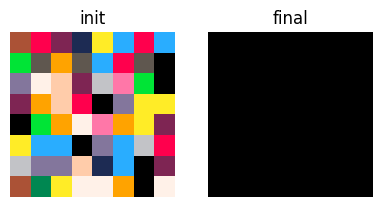

saving GIF 1070...: 100%|██████████| 1070/1070 [00:53<00:00, 19.96it/s]


In [65]:
# show the output from repairing a noise sprite
if EXPERIMENT == "normal":
    init_spr, cur_spr, anims = npod.repair(mod_iter='rand',num_iter=1069,animate=True)
    showMultiSprPalette([init_spr,cur_spr],textArr=['init','final'])

    # save the animation
    animatePal(anims,f"../prelim_output/pod_anim/npod_{GEN_CONF['EPOCHS']}e_w{GEN_CONF['WINDOW']}-2.gif",fps=32,textArr=[f"Iter: {i}" for i in range(len(anims))])

#### NPOD Sanity Checks

(8, 8)
(2, 2)
(8, 8)


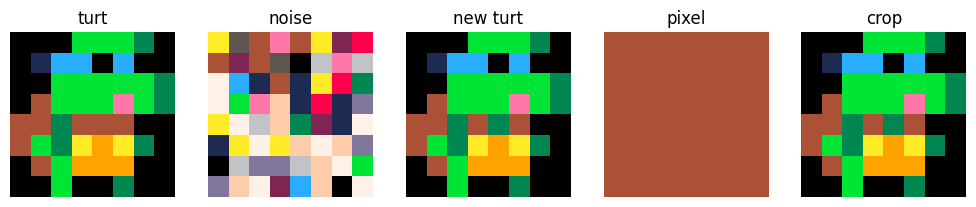

In [50]:
if EXPERIMENT == "normal" and CONFIGS["normal"]["SANITY"]:
    # test destroy function
    turt_spr = pico_char_dat[30]
    n_spr = npod.init_noise_sprite()

    pos = (4,4)
    a,b,c = npod.destroy(turt_spr,n_spr,pos,crop_size=8)
    b2d = np.full((2,2),b)
    print(a.shape)
    print(b2d.shape)
    print(c.shape)

    # showMultiSprPalette([turt_spr,n_spr], ['turt','noise'])
    showMultiSprPalette([turt_spr,n_spr,a,b2d,c],textArr=['turt','noise','new turt','pixel','crop'])


In [ ]:
# test train data creation
if EXPERIMENT == "normal" and CONFIGS["normal"]["SANITY"]:
    turt_spr = pico_char_dat[30]
    tdat = npod.make_train_dat([turt_spr],num_noise_spr=1)
    print(len(tdat))

100%|██████████| 1/1 [00:00<00:00, 288.68it/s]

64


In [66]:
# test output of the model
if EXPERIMENT == "normal" and CONFIGS["normal"]["SANITY"]:
    turt_spr = pico_char_dat[0].copy()
    turt_spr2 = turt_spr.copy()
    turt_spr2[4,2] = 14
    _,c = npod.crop(turt_spr2,(4,2),5)
    print(c.shape)

    #fix the sprite
    new_px = npod.pod_model.predict(np.array([c]),verbose=False)
    turt_spr3 = np.copy(turt_spr2)
    turt_spr3[4,2] = np.argmax(new_px)

    showMultiSprPalette([turt_spr,turt_spr2,turt_spr3],textArr=['OG','destroy','repair'])

### TEXT ENCODED PoD

---

#### Notes




In [206]:
class TECPoD():
    def __init__(self,spr_shape, channels=16, pad_val=0, crop_size=5):
        self.destroy_data = []
        self.spr_shape = spr_shape
        self.channels = channels
        self.pad_val = pad_val
        self.crop_size = crop_size

        self.ENC_SIZE = 768

    # make a new noisy sprite using the channels and size
    def init_noise_sprite(self):
        noise_spr = np.random.randint(self.channels,size=(self.spr_shape[0],self.spr_shape[1]))
        return noise_spr

    # crop a sprite from the noise sprite (use with padding) - assume pos is (x,y) and center of target crop
    def crop(self, spr, pos, size=5):
        hpad = size//2
        pad_spr = np.pad(spr,((hpad,hpad),(hpad,hpad)),constant_values=self.pad_val)   # pad the sprite 
        crop_spr = pad_spr[pos[0]:pos[0]+size,pos[1]:pos[1]+size]   # get the cropped sprite (should be size,size)
        return pad_spr, crop_spr

    # return the new level and the tile replaced (also add to training data) - assume pos is (x,y)
    def destroy(self, cur_spr, bad_spr, pos, crop_size=5):
        # turn the cur_spr value at the pos to the bad_spr value
        cur_spr2 = np.copy(cur_spr)
        og_val = cur_spr[pos[0],pos[1]]
        cur_spr2[pos[0],pos[1]] = bad_spr[pos[0],pos[1]]

        # crop around the area and add to training data
        _, crop_spr = self.crop(cur_spr2,pos,crop_size)

        return cur_spr2, og_val, crop_spr
    
    # calculate the hamming distance from 2 sprites
    def calc_ham_dist(self, spr1, spr2):
        return np.sum(spr1 != spr2)

    # return the sprite that is closest in hamming distance from the goal set
    def closest_spr(self, goal_set, noise_spr):
        min_dist_i = np.argmin([self.calc_ham_dist(noise_spr, i) for i in goal_set])
        return goal_set[min_dist_i]

    
    # make the training data for the path of destruction
    def make_train_dat(self,goal_img_set,goal_enc_set,num_noise_spr=1000):
        train_dat = []
        with tqdm(total=num_noise_spr) as pbar:
            for i in range(num_noise_spr):
                # make a noise sprite and find the closest
                # noise_spr = self.init_noise_sprite()
                # targ_spr = self.closest_spr(goal_set,noise_spr).copy()

                #go through each goal sprite (with associated annotation) and make a noise sprite for it
                targ_spr = goal_img_set[i%len(goal_img_set)]
                in_enc = goal_enc_set[i%len(goal_enc_set)]
                noise_spr = self.init_noise_sprite()

                # make a list of all the positions in the sprite and shuffle it
                pos_set = []
                for x in range(self.spr_shape[0]):
                    for y in range(self.spr_shape[1]):
                        pos_set.append((x,y))
                random.shuffle(pos_set)

                # iterate over the goal sprite and change until it matches the noise spr (destroy)
                for p in pos_set:
                    # destroy the noise sprite
                    targ_spr, og_val, crop_spr = self.destroy(targ_spr,noise_spr,p,self.crop_size)
                    train_dat.append([crop_spr,in_enc,og_val])
                    # showSprPalette(targ_spr)
                pbar.update(1)
                    
        return train_dat
    
    # make the path of destruction neural network model
    # copy of architecture from the paper [Conv(128,3) -> Conv(128,3) -> MaxPool(2), Conv(256,3)]
    # it doesn't work though... at least not with 5x5 crop size - need to ask Sam for exact implementation
    def makePoDCNN(self):

        # image input
        in1 = Input(shape=(self.crop_size,self.crop_size,1))
        in1 = Lambda(lambda x: K.cast(x, dtype='float32'))(in1)

        # text encoding input
        in2 = Input(shape=(self.ENC_SIZE,)),
        in2r = K.reshape(in2,(-1,8,8,12))
        in2f = Flatten()(in2r)
        in2d = Dense(self.crop_size*self.crop_size)(in2f)
        in2r2 = K.reshape(in2d,(-1,self.crop_size,self.crop_size,1))
        # in2r2 = Conv1D(1, 3, activation='relu',padding='SAME')(in2r)

        # combined and sent through the CNN
        x = Concatenate(axis=-1)([in1,in2r2])
        x = Conv2D(128, (3, 3), activation='relu',padding='SAME')(x)
        x = MaxPooling2D((2, 2))(x)
        x = Conv2D(128, (3, 3), activation='relu',padding='SAME')(x)
        x = Conv2D(256, (3, 3), activation='relu',padding='SAME')(x)
        x = Flatten()(x)
        x = Dense(128)(x)
        out1 = Dense(self.channels,activation='softmax')(x)

        self.pod_model = Model(inputs=[in1,in2], outputs=out1)
        self.pod_model.summary()
        self.opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
        self.pod_model.compile(optimizer=self.opt,metrics=['accuracy'],loss='sparse_categorical_crossentropy') #not one-hot encoded
        
        
    # import a model from a path
    def importModel(self,model_path):
        self.pod_model = tf.keras.models.load_model(model_path)
        self.pod_model.summary()
        self.opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
        self.pod_model.compile(optimizer=self.opt,metrics=['accuracy'],loss='sparse_categorical_crossentropy')


    # export the model to a path
    def exportModel(self,model_path):
        self.pod_model.save(model_path,save_format='h5')
                            

    # train the path of destruction model on the training data
    def trainPoD(self,train_dat,EPOCHS=500,BATCH_SIZE=64,show_acc=False):
        # train the model
        X1 = np.array([i[0] for i in train_dat])
        X2 = np.array([i[1] for i in train_dat])
        Y = np.array([i[2] for i in train_dat])
        X1 = np.expand_dims(X1,axis=-1)
        # X2 = np.expand_dims(X2,axis=-1)
        Y = np.expand_dims(Y,axis=-1)
        print(X1.shape,X2.shape,Y.shape)

        h = self.pod_model.fit([X1,X2],Y,epochs=EPOCHS,batch_size=BATCH_SIZE,shuffle=True)
        if show_acc:
            plt.plot(h.history['accuracy'])
            plt.show()

    # repair from a noise vector
    def repair(self,text_in,init_spr=None,mod_iter='rand',eval_met='iter',num_iter=1000,animate=False):
        #encode the text
        text_enc = sentEmb(text_in)
        text_enc = np.expand_dims(text_enc,axis=0)
        print(text_enc.shape)

        # make a noise sprite
        if init_spr is None:
            init_spr = self.init_noise_sprite()
        cur_spr = np.copy(init_spr)

        if animate:
            anim_set = []
            anim_set.append(cur_spr)

        # iterate over the noise sprite and change until the iterations are done
        pi = 0
        if eval_met == "iter":
            with tqdm(total=num_iter) as pbar:
                for i in range(num_iter):
                    #select a position (randomly or sequentially)
                    if mod_iter == "rand":
                        x = np.random.randint(self.spr_shape[0])
                        y = np.random.randint(self.spr_shape[1])
                    else:
                        x = pi%self.spr_shape[0]
                        y = pi//self.spr_shape[0]
                        pi += 1
                        if pi >= self.spr_shape[0]*self.spr_shape[1]:
                            pi = 0

                    pbar.set_description("@ ({},{})".format(x,y))

                    #crop the area
                    _, crop_spr = self.crop(cur_spr,(x,y),self.crop_size)

                    # preproc
                    crop_spr = np.expand_dims(np.expand_dims(crop_spr,axis=-1),axis=0)  #make it a batch of 1
                    
                    
                    # get the pixel change input from the model
                    # pred_px = self.pod_model.predict(np.array([crop_spr,text_enc]),verbose=False)
                    pred_px = self.pod_model.predict([crop_spr,text_enc],verbose=False)

                    # change the tile
                    cur_spr[x,y] = np.argmax(pred_px)

                    anim_set.append(cur_spr.copy())

                    pbar.update(1)

        if animate:
            return init_spr, cur_spr, anim_set
        return init_spr, cur_spr

if EXPERIMENT == "text_enc":
    # Make the Path of Destruction  model with the text encoded input
    tepod = TECPoD((8,8),channels=16,crop_size=GEN_CONF['WINDOW'])     
    tepod.makePoDCNN() 

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_120 (InputLayer)         [(None, 768)]        0           []                               
                                                                                                  
 tf.reshape_40 (TFOpLambda)     (None, 8, 8, 12)     0           ['input_120[0][0]']              
                                                                                                  
 flatten_35 (Flatten)           (None, 768)          0           ['tf.reshape_40[1][0]']          
                                                                                                  
 dense_72 (Dense)               (None, 64)           49216       ['flatten_35[1][0]']             
                                                                                           

In [153]:
if EXPERIMENT == "text_enc":

    if CONFIGS["text_enc"]["NEW_TRAIN_DAT"]:
        # make the training data
        goal_spr_char = pico_char_dat.copy()
        goal_enc_char = pico_char_labels_emb.copy()
        train_dat = tepod.make_train_dat(goal_spr_char,goal_enc_char,num_noise_spr=(len(goal_spr_char)*10))

        # ninja turtle set
        # turtle_spr_char = pico_char_dat[30:34]
        # showMultiSprPalette(turtle_spr_char)
        # train_dat = npod.make_train_dat(turtle_spr_char,num_noise_spr=(len(turtle_spr_char)*100))

        print(len(train_dat))
        print(train_dat[0][0].shape,train_dat[0][1].shape,train_dat[0][2])

        # export as .npy file
        np.save(CONFIGS["text_enc"]["TRAIN_DAT_PATH"],train_dat)
    else:
        # import the training data
        train_dat = np.load(CONFIGS['text_enc']["TRAIN_DAT_PATH"],allow_pickle=True)
        print(len(train_dat))

64000


In [207]:
# train or import the model
if EXPERIMENT == "text_enc":
    if CONFIGS["text_enc"]["TRAIN_TEPOD"]:
        tepod.trainPoD(train_dat,EPOCHS=GEN_CONF['EPOCHS'],BATCH_SIZE=GEN_CONF['BATCH_SIZE'],show_acc=True)
        tepod.exportModel(CONFIGS["text_enc"]["TEPOD_MODEL"])
    else:
        tepod.importModel(CONFIGS["text_enc"]["TEPOD_MODEL"])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 768)]        0           []                               
                                                                                                  
 tf.reshape (TFOpLambda)        (None, 8, 8, 12)     0           ['input_2[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 768)          0           ['tf.reshape[0][0]']             
                                                                                                  
 dense (Dense)                  (None, 64)           49216       ['flatten[0][0]']                
                                                                                              

(1, 768)


@ (7,7): 100%|██████████| 192/192 [00:09<00:00, 19.99it/s]


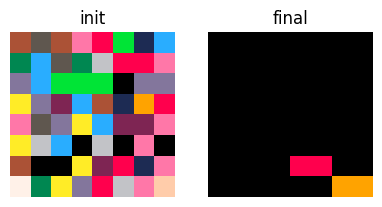

saving GIF 193...: 100%|██████████| 193/193 [00:09<00:00, 19.57it/s]


In [230]:

TEXT = "a man with yellow pants" 
# show the output from repairing a noise sprite
if EXPERIMENT == "text_enc":
    init_spr, cur_spr, anims = tepod.repair(TEXT,mod_iter='seq',num_iter=192,animate=True)
    showMultiSprPalette([init_spr,cur_spr],textArr=['init','final'])

    # save the animation
    animatePal(anims,f"../prelim_output/pod_anim/tepod_{GEN_CONF['EPOCHS']}e_w{GEN_CONF['WINDOW']}-yellow_pants_man.gif",fps=32,textArr=[f"Iter: {i}" for i in range(len(anims))])

#### Sanity Check

In [183]:
x = np.array([init_spr,sentEmb(TEXT)])
x = tf.cast(x,tf.float32)
# print(x)
tepod.pod_model.predict(x)

/var/folders/5h/0zjb1m296y1gvhtd9q40w4yc0000gn/T/ipykernel_6927/3430132365.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.array([init_spr,sentEmb(TEXT)])


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).

In [202]:
# img = np.expand_dims(init_spr,axis=-1)
_, img = tepod.crop(init_spr,(4,4),8)
img = np.expand_dims(np.expand_dims(img,axis=-1),axis=0)
e = np.expand_dims(sentEmb(TEXT),axis=0)
print(img)
print(e)

print(img.shape,e.shape)

tepod.pod_model.predict([img,e])

[[[[ 4]
   [ 8]
   [ 2]
   [ 1]
   [10]
   [12]
   [ 8]
   [12]]

  [[11]
   [ 5]
   [ 9]
   [ 5]
   [12]
   [ 8]
   [ 5]
   [ 0]]

  [[13]
   [ 7]
   [15]
   [ 2]
   [ 6]
   [14]
   [11]
   [ 0]]

  [[ 2]
   [ 9]
   [15]
   [ 8]
   [ 0]
   [13]
   [10]
   [10]]

  [[ 0]
   [11]
   [ 9]
   [ 7]
   [14]
   [ 9]
   [10]
   [ 2]]

  [[10]
   [12]
   [12]
   [ 0]
   [13]
   [12]
   [ 6]
   [ 8]]

  [[ 6]
   [13]
   [13]
   [15]
   [ 1]
   [12]
   [ 0]
   [ 2]]

  [[ 4]
   [ 3]
   [10]
   [ 7]
   [ 7]
   [ 9]
   [ 0]
   [ 7]]]]
[[-3.06603551e-01 -5.21848910e-02 -2.39456630e+00  3.94117497e-02
   1.16880012e+00 -4.50373173e-01 -1.70885360e+00 -1.10859394e-01
  -6.38351381e-01 -3.49628270e-01 -5.46912849e-01  1.46670485e+00
   3.54589045e-01 -1.33053362e-01  4.06604171e-01  1.05487527e-02
  -6.32065475e-01 -8.06774423e-02 -9.18105841e-02  7.95490205e-01
  -7.04753757e-01 -3.07381243e-01 -7.42180347e-01 -6.82968557e-01
   5.07640302e-01 -5.25882952e-02 -1.67007625e-01  1.05655760e-01
  -7.4936

array([[8.0725272e-07, 3.8834944e-16, 3.8286574e-12, 2.4268692e-04,
        9.8936123e-01, 1.6406036e-08, 3.6607117e-03, 6.7233262e-03,
        1.5686749e-13, 1.0776702e-05, 1.2969760e-11, 4.1335880e-12,
        9.8043373e-10, 1.5044901e-18, 3.5768513e-16, 4.8433805e-07]],
      dtype=float32)

In [200]:
d = train_dat[0]
print(d[0].shape,d[1].shape,d[2].shape)

(8, 8) (768,) ()
